# Normalizing Flows - Home Assignment

Welcome to this notebook project on normalizing flows, a powerful and expressive family of invertible generative models. We will start with simple 1D Gaussian distributions and progressively build up to more complex image data, such as the MNIST and CelebA datasets.

Throughout this project, you will:

1. Gain a solid understanding of the fundamental concepts behind normalizing flows, including probability density transformation and the change of variables formula.
2. Implement an affine flow to model a 1D Gaussian distribution and learn about its limitations when dealing with more complex data.
3. Explore the affine coupling flow and its ability to model a 2D Gaussian mixture distribution.
4. Apply the lessons learned from the 1D and 2D examples to image data by implementing a RealNVP-like flow with more complex coupling networks and masking approaches.
5. Learn about dequantization, squeeze, and split flows to improve the performance of your model on multiscale image data.
6. Train your RealNVP-like flow on the MNIST and/or CelebA datasets and evaluate the quality of the generated samples.
7. Perform interpolation and latent space manipulation to showcase the expressive power of normalizing flows.

In [1]:
from abc import ABC, abstractmethod
from typing import Tuple, List, Set, Callable
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution, Normal
import pytorch_lightning as pl

from tests import *
from utils import *

device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cuda:0


## Flows and Normalizing Flows


Recall that the primary goal of normalizing flows is to transform a simple base distribution (e.g., Gaussian) into a more complex distribution by learning a series of invertible transformations. The change of variables formula plays a crucial role in this process. The formula is as follows:

$$
p_X(x) = p_Z(f(x)) \left|\det\frac{\partial f(x)}{\partial x}\right|.
$$

The absolute value of the determinant of the Jacobian, $\left|\det\frac{\partial f(x)}{\partial x}\right|$, is essential as it accounts for the change in probability density due to the transformation.

In the provided skeleton classes, you will find methods that need to be implemented, such as forward, inverse, and log_prob. Your task is to implement these methods while keeping the change of variables formula in mind. Once you complete the implementation, the test_normflow function will help you verify the correctness of your implementation. Good luck, and enjoy building your own normalizing flows!


In [2]:
class Flow(nn.Module, ABC):
    """Base class for flows."""

    @abstractmethod
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Run the flow in the normalizing direction (x -> z).
        
        Args:
            x: Input tensor [B, ...]
        Returns:
            z: The transformed input. [B, ...]
            log_det_jacobian: The log determinant of the jacobian. [B]
        """
        

    @abstractmethod
    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """Run the flow in the inverse direction (z -> x).
        
        Args:
            z: Input tensor [B, ...]
        Returns:
            x: The transformed input [B, ...]
        """


class NormalizingFlow(Flow):
    """Base class for normalizing flows.
    
    A normalizing flow is a composition of flows, where the output of one flow is
    the input of the next flow. The base distribution is the distribution that
    the flow is trying to approximate.
    
    """

    def __init__(self, flows: List[Flow], base_distribution: Distribution):
        """Initializes a flow with a given base distribution."""
        super().__init__()
        # Note that the base distribution can be of lower dimensionality than the flow,
        # e.g. a 1D base distribution for a 2D flow. This is useful to keep things
        # simple when we move to higher dimensions, for example image flows.
        self.base_distribution = base_distribution
        assert len(flows) > 0, "Need at least one flow."
        self.flows = nn.ModuleList(flows)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """see Flow.forward"""
        log_det_jacobian = torch.zeros(x.shape[0], device=x.device)

        for flow in self.flows:
            x, jac = flow(x) 
            log_det_jacobian += jac

        z = x

        return z, log_det_jacobian

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """see Flow.inverse"""

        n = len(self.flows)
        for i in range(n):
            z = self.flows[n-i-1].inverse(z)
        x = z

        return x
        
    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        """Log probabilities of each sample in x.
        
        Args:
            x: Input tensor [B, ...]
        Returns:
            log_prob: Log probabilities of each sample in x. [B]
        
        """
        z, log_det = self.forward(x)
        z_log_prob = self.base_distribution.log_prob(z)
        if len(z_log_prob.shape) > 1:
            z_log_prob = z_log_prob.sum(list(range(1, len(z_log_prob.shape))))

        log_prob = z_log_prob + log_det

        return log_prob

    def nll(self, x: torch.Tensor) -> torch.Tensor:
        """Negative log likelihood, averaged over all samples in the given batch."""
        return -self.log_prob(x).mean()

    @torch.no_grad()
    def sample(self, shape: torch.Size) -> torch.Tensor:
        """Sample from the flow."""
        z = self.base_distribution.sample(shape)

        x = self.inverse(z) 
        
        return x


test_normflow(NormalizingFlow)

✓ All tests passed! :) 


## 1D toy example

In this section, we will explore a simple one-dimensional normalizing flow using an affine transformation.

We will start off by generating a 1D dataset from a non-standard Gaussian distribution. We will use a standard normal distribution as our base distribution for the normalizing flow, so we need to make sure that the target distrubution is at least a little bit different.


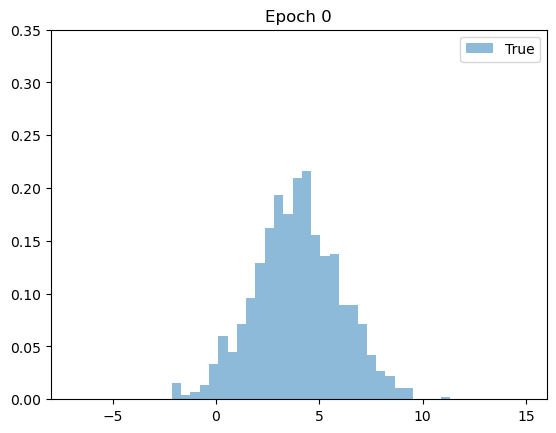

In [3]:
def generate_gaussian(num_samples: int = 1000) -> np.ndarray:
    return np.random.normal(loc=4, scale=2, size=num_samples)


data_1d = torch.tensor(generate_gaussian(1000), dtype=torch.float32)
vis_1d(data_1d)

Next, we provide a skeleton for the AffineFlow class, which inherits from the Flow class. This class performs an affine transformation on the input data, scaling and shifting it using learnable parameters. Your task is to implement the forward and inverse methods for this class.

In [4]:
class AffineFlow(Flow):
    """An affine flow."""

    def __init__(self, input_dim=1):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(input_dim))
        self.shift = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """see Flow.forward"""
        z = x * torch.exp(self.scale) + self.shift
        log_det_jacobian = torch.zeros(x.shape[0], device=x.device)
        log_det_jacobian[:] = torch.sum(self.scale)
        
        return z, log_det_jacobian

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """see Flow.inverse"""
        x = (z-self.shift) * torch.exp(-self.scale) 
        return x

# unittest by forward backward check
testdata = torch.tensor(generate_gaussian(100), dtype=torch.float32)
testflow = AffineFlow(1)
test_flow(testflow, testdata)

✓ Forward-Backward check passed 


Here we have provided you with a training loop, your only task is to implement the loss


In [5]:
def train_flow(
    flow: NormalizingFlow,
    data_func: Callable,
    batch_size: int,
    num_epochs: int,
    vis_func: Callable,
    vis_epochs: Set[int],
    lr=1e-3,
):
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    log_interval = num_epochs // 10
    for epoch in range(num_epochs):
        train_data = torch.tensor(data_func(batch_size), dtype=torch.float32)
        optimizer.zero_grad()

        loss = flow.nll(train_data)
        
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")
        if vis_epochs and epoch in vis_epochs:
            vis_func(flow=flow, epoch=epoch)

Finally, it's time to train your first flow! Instantiate your flow, and don't forget to pick a suitable base distribution, for instance a standard gaussian.


Epoch 0/5000, Loss: 76.40008544921875
Epoch 500/5000, Loss: 30.282442092895508
Epoch 1000/5000, Loss: 14.991399765014648
Epoch 1500/5000, Loss: 9.079427719116211
Epoch 2000/5000, Loss: 5.282534599304199
Epoch 2500/5000, Loss: 3.937443494796753
Epoch 3000/5000, Loss: 2.9776315689086914
Epoch 3500/5000, Loss: 2.5590593814849854
Epoch 4000/5000, Loss: 2.346461534500122
Epoch 4500/5000, Loss: 2.090852975845337


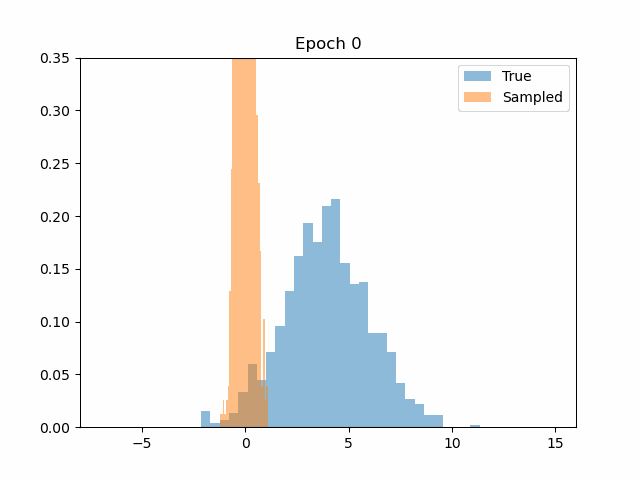

In [10]:
base_distribution = torch.distributions.Normal(0.0, 1.0)
flow = NormalizingFlow(
    flows=[AffineFlow(1)],
    base_distribution=base_distribution,
)

num_epochs = 5000
batch_size = 512
vis_func = partial(vis_1d, data=data_1d, output_dir="output-1d")
vis_epochs = {*range(0, num_epochs, 100)} | {num_epochs - 1}
train_flow(flow, generate_gaussian, batch_size, num_epochs, vis_func, vis_epochs)
create_gif(output_dir="output-1d", epochs=sorted(vis_epochs))

## Expand to a 2d example

In this section, we will expand our normalizing flow example to a 2D mixture of Gaussians with 4 modes. You might recognize this from the GAN assignment.

First, let's create and visualize the 2D mixture of Gaussians with 4 modes:

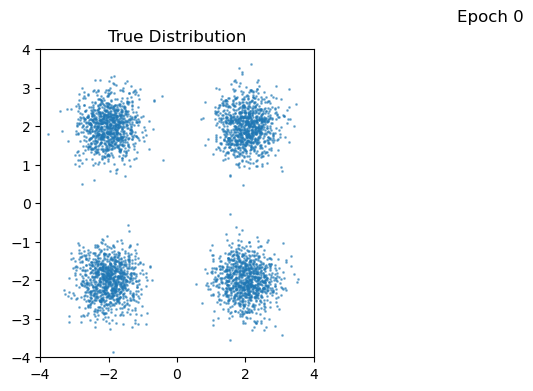

In [11]:
def generate_mixture_of_gaussians(num_samples: int = 1000) -> np.ndarray:
    # If you go outside -4,4 you will need to update the xlim and ylim arguments to vis_2d :)
    means = [[-2, -2], [2, 2], [-2, 2], [2, -2]]
    cov = np.eye(2) * 0.2
    samples = []
    for mean in means:
        samples.append(
            np.random.multivariate_normal(mean, cov, size=num_samples // len(means))
        )
    return np.vstack(samples)


data_2d = torch.tensor(generate_mixture_of_gaussians(4000), dtype=torch.float32)
vis_2d(data_2d)

Now, we will attempt to model the 2D distribution using affine flows, as we did in the 1D example.

However, this approach will not work well, as the affine transformation is not flexible enough to model the distribution. Later, we will construct a more complex normalizing flow to better model the distribution.

Epoch 0/1000, Loss: 12282.146484375
Epoch 100/1000, Loss: 6061.43896484375
Epoch 200/1000, Loss: 3657.981201171875
Epoch 300/1000, Loss: 2526.48828125
Epoch 400/1000, Loss: 1806.9039306640625
Epoch 500/1000, Loss: 1368.449951171875
Epoch 600/1000, Loss: 1093.8074951171875
Epoch 700/1000, Loss: 902.6298217773438
Epoch 800/1000, Loss: 743.2984008789062
Epoch 900/1000, Loss: 629.0338134765625


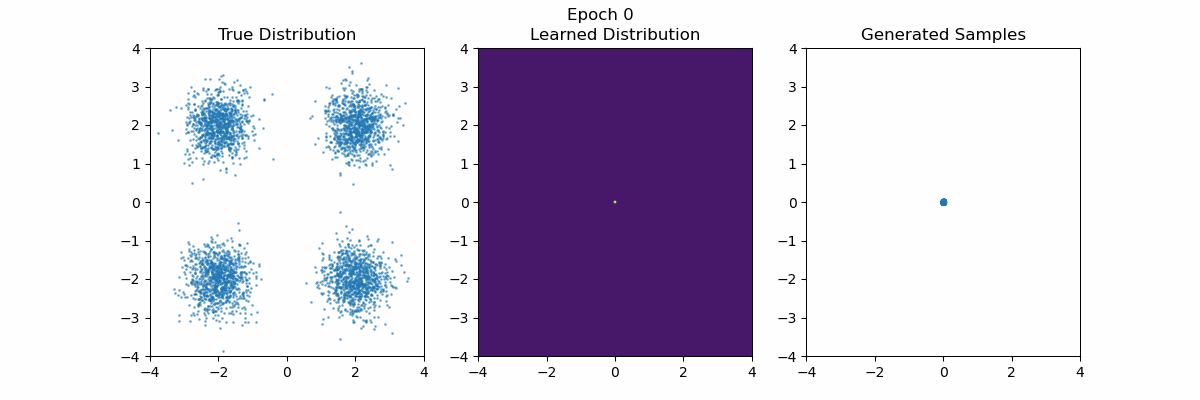

In [14]:
flow = NormalizingFlow(
    flows=[AffineFlow(2) for _ in range(4)],
    base_distribution=base_distribution,  # reuse the 1D base distribution (but you could use MultivariateNormal here instead)
)
data_func = generate_mixture_of_gaussians

num_epochs = 1000
batch_size = 512
vis_func = partial(vis_2d, data=data_2d, output_dir="output-2d-simple")
vis_epochs = {*range(0, num_epochs, 20)} | {num_epochs - 1}
train_flow(flow, data_func, batch_size, num_epochs, vis_func, vis_epochs)
create_gif(output_dir="output-2d-simple", epochs=sorted(vis_epochs))

### Coupling Flow

Now we have seen that just stacking affine flows is not enough. So let us create a more complex transformation, namely a coupling affine flow.

Quick recap:

* Coupling flow: $y_1 = x_1$, $y_2 = h(x_2, \theta(x_1))$
* Affine transformation: $h(x) = \mu + \sigma x$
* Coupling affine flow: $y_1 = x_1$, $y_2 = \mu_2 + \sigma_2 x_2$, where $(\mu_2, \sigma_2) = \theta(x_1)$.
* \theta is typically a neural network.

A few implementation tips:

* a simple 2-layer MLP with ReLU activations should be enough. We have provided you with a simple MLP skeleton, but feel free to do something more complex if you want.
* you can parametrize the scale as $\log \sigma_2 = a * tanh(MLP(x_1)) + b$, where $a$ and $b$ are learnable
* pass the entire input to the MLP after applying a mask, instead of splitting the input into two parts
* alternate which dimension you apply the coupling affine flow to (invert the masking)


In [15]:
class MLP(nn.Module):
    """A simple multi-layer perceptron."""

    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []

        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class AffineCouplingFlow(Flow):
    def __init__(self, network: nn.Module, mask: torch.Tensor, in_channels: int = 1):
        """Coupling layer inside a normalizing flow."""
        super().__init__()
        self.network = network  # Network should output 2 * in_channels
        self.scale = nn.Parameter(torch.ones(in_channels), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(in_channels), requires_grad=True)
        self.register_buffer("mask", mask)

    def _compute_coupling_parameters(self, x):
        x = x * self.mask
        log_s, t = self.network(x).chunk(2, dim=1) # sigma, mu
        scale = self.scale.view(1, -1, *([1] * (len(x.shape) - 2))) # a
        scale_shift = self.scale_shift.view(1, -1, *([1] * (len(x.shape) - 2))) # b
    
        # log sigma = a * tanh(network(x)) + b
        log_s = scale * torch.tanh(log_s) + scale_shift
        
        # Mask outputs (only transform the second part)
        log_s = log_s * (1 - self.mask)
        t = t * (1 - self.mask)
        return log_s, t

    def forward(self, x):
        log_s, t = self._compute_coupling_parameters(x)

        z = x * torch.exp(log_s) + t
        log_det_jacobian = log_s
        
        non_batch_dims = list(range(1, len(log_s.shape)))
        log_det_jacobian = log_det_jacobian.sum(non_batch_dims)
        return z, log_det_jacobian

    def inverse(self, z):
        log_s, t = self._compute_coupling_parameters(z)
        x = (z-t) * torch.exp(-log_s)

        return x
    
testdata = torch.tensor(generate_mixture_of_gaussians(100), dtype=torch.float32)
testflow = AffineCouplingFlow(
    network=MLP(2, 2, 32, 4),
    mask=torch.tensor([1, 0], dtype=torch.float32),
    in_channels=2,
)
test_flow(testflow, testdata)

✓ Forward-Backward check passed 


Now let's train it! 

Note: Don't worry if your flow has some narrow lines connecting the modes, as long as it captures the general shape of the distribution.

Epoch 0/2000, Loss: 6.022863388061523
Epoch 200/2000, Loss: 2.863351821899414
Epoch 400/2000, Loss: 2.7242190837860107
Epoch 600/2000, Loss: 2.745450973510742
Epoch 800/2000, Loss: 2.7292213439941406
Epoch 1000/2000, Loss: 2.680309772491455
Epoch 1200/2000, Loss: 2.7932865619659424
Epoch 1400/2000, Loss: 2.6806893348693848
Epoch 1600/2000, Loss: 2.656567335128784
Epoch 1800/2000, Loss: 2.692216157913208


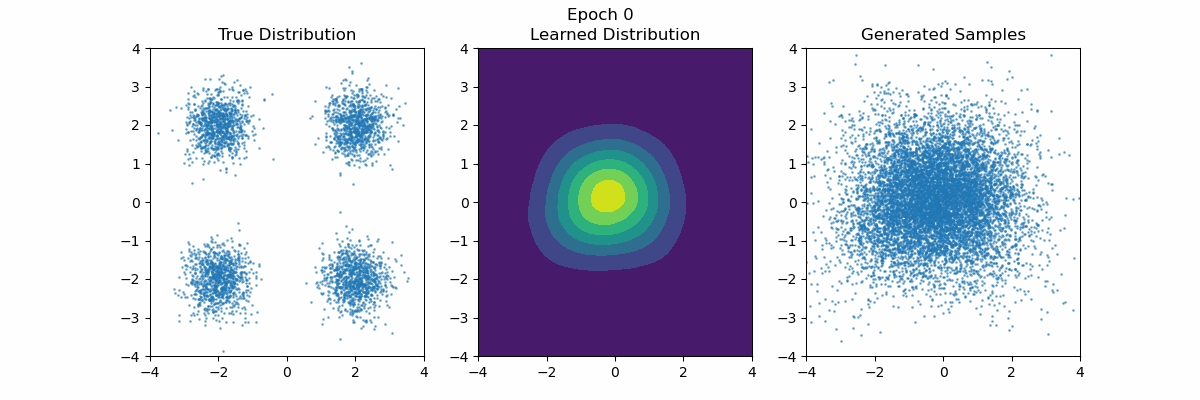

In [16]:
num_epochs = 2000
batch_size = 512
num_layers = 8
flow = NormalizingFlow(
    flows=[
        AffineCouplingFlow(
            network=MLP(2, 2, 64, 4),  # Feel free to change the network architecture
            mask=torch.tensor(
                [int(i % 2 == 0), int(i % 2 == 1)], dtype=torch.float32
            ),  # Use alternating masks
            in_channels=2,
        )
        for i in range(num_layers)
    ],
    base_distribution=base_distribution,  # reuse the 1D base distribution
)

vis_func = partial(vis_2d, data=data_2d, output_dir="output-2d-coupling")
# Extra many plots in the beginning since that it is where the evolution is most interesting
vis_epochs = {*range(0, 500, 20)} | {*range(500, num_epochs, 50)} | {num_epochs - 1}
vis_epochs = {epoch for epoch in vis_epochs if epoch < num_epochs}
train_flow(flow, data_func, batch_size, num_epochs, vis_func, vis_epochs)
create_gif(output_dir="output-2d-coupling", epochs=sorted(vis_epochs))

If the learned distributions and generated samples look close to your target distribution, you have successfully implemented a coupling affine flow. Congratulations!

**Question**: Finally, let us reflect on the 2d mixture of Gaussians example. Why is the coupling affine flow able to model the distribution much better than a stack of affine flow? Also, how would you design a normalizing flow to model the 2d mixture of Gaussians if you were allowed to bake in prior knowledge about the distribution?

For a gaussian distribution, stacking affine flows will result in a transformation which shifts the mean and scales the variance. A non-linearity, such as coupling affine flows, is non-linear and enables the flexibility to model multi modal distributions. The extent of flexibility is not trivial though I guess.

I think one can use the knowledge of what one is modelling and make the transformation less challenging by selecting the base distribution to be mixture of Gaussians.

# Normalizing Flows for Images

Now that we have a good understanding of normalizing flows, let's apply them much more complex data - namely images.

We will primarily use our MNIST-like downscaled CelebA dataset for this part of the assignment, but it's plug and play with mnist. You might want to perform the initial steps with MNIST, since samples from the CelebA dataset are more complex and it might be harder to get a good model. It might also be easier to build intuition with MNIST, since classes are so distinct. Nevertheless, MNIST is entirely optional, and you can just use CelebA from the beginning.

Later on, after we have trained a good "face flow", we will experiment with interpolating and manipulating the latent space of the flow. This will allow us to generate new faces with different attributes, such as smiling, wearing glasses, etc.

Let's begin by loading the dataset and visualizing some samples.

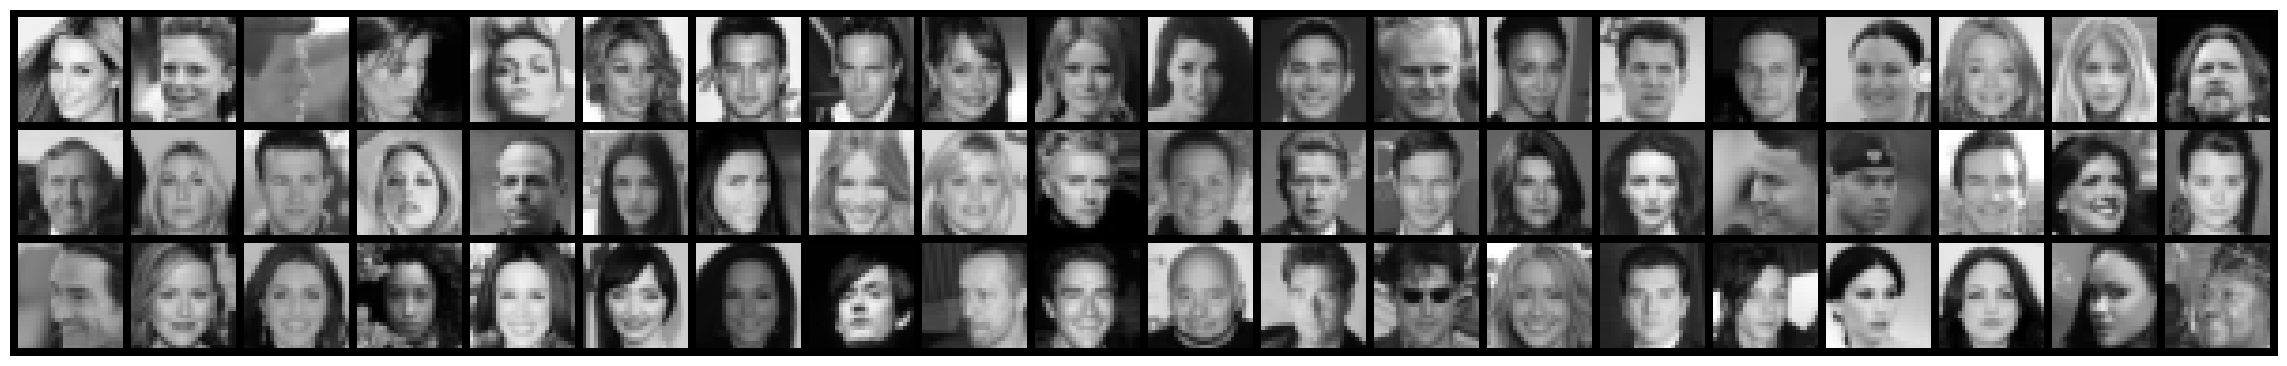

In [17]:
dataset = "celeba" # or "mnist"
train_set, train_data_loader, val_loader, test_loader = get_data(dataset)
show_imgs([train_set[i][0] for i in range(60)])

Next, we will introduce some more advanced flows, that are suitable for modeling images. This roughly follows the RealNVP paper, but we will not be implementing the full model exactly.

## Dequantization

A normalizing flow model provides an invertible mapping from the image space to the embedding space. However, images are often quantized as 8-bit unsigned integers with pixel values from 0 to 255. 
This is problematic because the model will learn to assign infinitely high probability to the integer values 0,1, ..., 255 (i.e. delta functions) and zero probability everywhere else.

A solution is to stochastically smoothens out the input pixels by adding uniform random noise in the range [0,1) to each pixel.
We will follow the strategy used in section 4.1 of the paper *Density Estimation Using Real-NVP* (https://arxiv.org/abs/1605.08803) and apply an additional transformation to the data after the addition of noise. 
This transformation maps the pixel values to a range that makes the network easier to train.

The dequantization layer has already been implemented below, and should be used as the first layer in your flow model.

In [18]:
class Dequantization(Flow):
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, x):
        z, ldj = self._dequant(x)
        z, ldj = self._inverse_sigmoid(z, ldj)
        return z, ldj

    def inverse(self, z):
        x = self._sigmoid(z)
        x = x * self.quants
        x = torch.floor(x).clamp(min=0, max=self.quants - 1).to(torch.int32)
        return x

    def _sigmoid(self, z):
        z = torch.sigmoid(z)
        z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        return z

    def _inverse_sigmoid(self, z, ldj):
        z = (
            z * (1 - self.alpha) + 0.5 * self.alpha
        )  # Scale to prevent boundaries 0 and 1
        ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
        ldj += (-torch.log(z) - torch.log(1 - z)).sum(dim=[1, 2, 3])
        z = torch.log(z) - torch.log(1 - z)
        return z, ldj

    def _dequant(self, x):
        # Transform discrete values to continuous volumes
        z = x.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj = -np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

## Coupling Flow - revisited

Here we can reuse the old affine coupling layer, but we need a different mask and a different coupling network, since the previous ones were only suitable for very simple data.

First we need to update the masking logic to work on image-like data. There are two common approaches to masking:
* checkerboard masking - the mask alternates between 0 and 1 for each spatial dimension
* channel masking - the mask alternates between 0 and 1 in the channel dimension

We have provided both here, and a small test to check that they work as expected with your affine coupling layer.

In [19]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing="ij")
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask


def create_channel_mask(c_in, invert=False):
    mask = torch.cat(
        [
            torch.ones(c_in // 2, dtype=torch.float32),
            torch.zeros(c_in - c_in // 2, dtype=torch.float32),
        ]
    )
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask


# Re-test the old coupling layer for image data. This should not fail, but if it does, you have to revisit the original implementation
testflow = AffineCouplingFlow(
    network=lambda x: torch.concat((x, x), dim=1),  # Dummy network with 2x out channels
    mask=create_checkerboard_mask(32, 32, invert=True),
    in_channels=4,
)
testdata = torch.rand(2, 4, 32, 32)
test_flow(testflow, testdata, "for image-like data")

✓ Forward-Backward check passed for image-like data


**Question**: Take a moment to reflect on the differences between the two approaches. Which one do you think will work better for images? Or perhaps we should use a combination of both? 
(visualizing the masks can help build some intuition)

===Your answer here===

Intuitively, it seems to me that masking in a checkerboard style is better than over specific channels for images. 

### Coupling Network 

As mentioned earlier, the coupling network has no requirements on inversion, so we can use any network we want.

We will give you some rough guidelines, but this part is mostly up to your imagination:
* You can make assumptions on (and take advantage of) the spatial structure of the data, for example by using convolutional layers.
* Start of with a relatively shallow network to keep the computational cost low.
  * You should get okish results with ~5 layers, but you can go deeper and increase the quality
  * Similarly, channel counts can be relatively low, e.g. 32 or 64
* Stacking Resnet-style blocks is a good idea if you want to make a deeper coupling network 

In [21]:


class ResidualBlock(nn.Module):
    """ResNet basic block with weight norm."""
    def __init__(self, in_channels):
        super().__init__()

        self.norm_in = nn.BatchNorm2d(in_channels)
        self.conv_in = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.norm_out = nn.BatchNorm2d(in_channels)
        self.conv_out = nn.Conv2d(in_channels, in_channels, kernel_size=2, padding=1)

    def forward(self, x):
        skip = x
        x = self.norm_in(x)
        x = F.relu(x)
        x = self.conv_in(x)
        x = self.norm_out(x)
        x = F.relu(x)
        x = self.conv_in(x)
        return x + skip
    

class CouplingNet(nn.Module):
    """Coupling network.
    
    This should be reasonably expressive, so we recommend building a network with multiple blocks.

    Each block could be a resnet-style block, a gated convolution, or something else altogether.
    """
    def __init__(self, c_in, c_hidden=64, num_layers=5):
        super().__init__()
        self.norm_in = nn.BatchNorm2d(c_in)
        self.conv_in = nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)
        self.skip_in = nn.Conv2d(c_hidden, c_hidden, kernel_size=1, padding=0)
        self.blocks = nn.ModuleList([ResidualBlock(c_hidden) for _ in range(num_layers)])
        self.skips = nn.ModuleList([nn.Conv2d(c_hidden, c_hidden, kernel_size=1, padding=0) for _ in range(num_layers)])     
        
        self.norm_out = nn.BatchNorm2d(c_hidden)
        self.conv_out = nn.Conv2d(c_hidden, 2*c_in, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.conv_in(F.relu(self.norm_in(x)))
        x_skip = self.skip_in(x)
        
        for block, skip in zip(self.blocks, self.skips):
            x = block(x)
            x_skip += skip(x)

        x = self.conv_out(F.relu(self.norm_out(x_skip)))
        return x


testflow = AffineCouplingFlow(
    network=CouplingNet(4),
    mask=create_checkerboard_mask(32, 32, invert=True),
    in_channels=4,
)
testdata = torch.rand(2, 4, 32, 32)
test_flow(testflow, testdata, "for image-like data")


✓ Forward-Backward check passed for image-like data


## Multi-scale image flow architecture

To efficiently work with high-dimensional inputs, such as images, it's useful to have a way to downsample and upsample the data. A popular way to accomplish this for normalizing flows is to use a combination of squeeze and split flows.

First, we will use a squeeze flow to downsample the image spatially by a factor of 2, at the expense of quadrupling the number of channels.

In [22]:
class SqueezeFlow(Flow):
    """Squeeze flow. Shuffles data from spatial dimensions to channels."""

    def forward(self, x):
        B, C, H, W = x.shape
        # Forward direction: H x W x C => H/2 x W/2 x 4C
        z = x.reshape(B, C, H // 2, 2, W // 2, 2)
        z = z.permute(0, 1, 3, 5, 2, 4)
        z = z.reshape(B, 4 * C, H // 2, W // 2)
        return z, torch.zeros(B, device=x.device)

    def inverse(self, z):
        B, C, H, W = z.shape
        # Reverse direction: H/2 x W/2 x 4C => H x W x C
        x = z.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x


test_input = torch.randn(1, 4, 32, 32)
testflow = SqueezeFlow()
test_flow(testflow, test_input)


✓ Forward-Backward check passed 


Then we will reduce the number of channels using a split flow, which splits the channels into two parts and basically terminates the flow for one of the parts.
When we want to run this splitting flow in reverse, we can simply sample the "discarded" part from our base distribution.

Note that this implementation of the split flow is not invertible, because we do not store the discarded half. This is not a problem, because we will only use the split flow in the forward or backward direction, never both. A more general, but less practical, implementation would store the discarded half and then be invertible.


In [23]:
class SplitFlow(Flow):
    """Split flow. Splits the input into two parts and discards one of them."""
    
    def __init__(self):
        super().__init__()
        self.base_distribution = Normal(loc=0.0, scale=1.0)

    def forward(self, x):
        z, z_split = x.chunk(2, dim=1)
        
        # Since we are discarding z_split, we need to compute its log probability here, not at the end of all flows
        log_prob_z_split = self.base_distribution.log_prob(z_split)
        
        # As a little trick, we pass along the log probability of z_split as the log determinant of the Jacobian
        ldj = log_prob_z_split
        ldj = ldj.sum(list(range(1, len(ldj.shape))))
        return z, ldj

    def inverse(self, z):
        z_split = self.base_distribution.sample(sample_shape=z.shape).to(device)
        x = torch.cat([z, z_split], dim=1)
        return x


# We cannot test the forward-backward consistency of this flow because it is not invertible
test_splitflow(SplitFlow)

✓ All tests passed! :) 


### Putting it all together

Now we can finally put all the pieces together and create a flow model that can properly model our celebrity faces.

Here you will be tasked with implementing a multi-scale flow model, inspired by [RealNVP](https://arxiv.org/abs/1605.08803).

To that end, implement the following flow model below:
- start of with a Dequantization flow.
- Add a couple (~2) affine coupling flows
  - use your new CouplingNet
  - and a checkerboard mask (remember to alternate the regular mask with the inverted one).
- Add a SqueezeFlow (think about what this does to the dimensions)
- Add a few more affine coupling flows (~4 or so)
  - this time you can try the channel mask instead of the checkerboard mask. However, you can also alternate between the two.
- Add both a SplitFlow and a SqueezeFlow (again think about dimensions)
- Finally, add some more affine coupling flows (~4 or so)
  - we recommend using the checkerboard mask here, but as always, feel free to experiment.


In [24]:
def create_multiscale_flow() -> NormalizingFlow:
    in_channels = 1
    img_sz = 28
    flows = []
    flows.append(Dequantization())
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=True),in_channels=in_channels,))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=False),in_channels=in_channels,))
    flows.append(SqueezeFlow())

    in_channels = int(in_channels*4)
    img_sz = int(img_sz/2)

    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels), mask=create_channel_mask(in_channels, invert=True),in_channels=in_channels))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels), mask=create_channel_mask(in_channels, invert=True),in_channels=in_channels))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=True),in_channels=in_channels,))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=False),in_channels=in_channels,))

    flows.append(SplitFlow())
    flows.append(SqueezeFlow())

    in_channels = int(in_channels*2)
    img_sz = int(img_sz/2)

    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=True),in_channels=in_channels,))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=False),in_channels=in_channels,))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=True),in_channels=in_channels,))
    flows.append(AffineCouplingFlow(network=CouplingNet(in_channels),mask=create_checkerboard_mask(img_sz, img_sz, invert=False),in_channels=in_channels,))

    prior = Normal(torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))
    return NormalizingFlow(flows, prior)

print_num_params(create_multiscale_flow())

Number of parameters: 2,968,620


You might need to revisit the flow you just built, if you aren't getting good results. In that case we have some tips on what to focus on.

Good candidates for tweaking:
* architecture of the coupling network
* number of flows in each scale
* additional layers in each scale (e.g. ActNorm or Invertible1x1Conv from GLOW)
* hidden channel count(s) in the coupling networks

Not recommended for tweaking:
* changing the number of scales
* moving the dequantization layer

## Train the image flow

We will train the flow using pytorch lightning. We have hidden away all the details inside lightning.py, but feel free to look and change the code if you want.

Some guidelines:
* The model should be able to learn something resembling faces after ~10 epochs
* To get good looking faces you will need to train for a long time, e.g. 50-100 epochs (This is not required, but makes subsequent tasks more fun)
* You can switch from CELEBA to MNIST by changing the `dataset` argument to `celeba` or `mnist` in the beginning of the image section. However, we have downscaled CELEBA to have the same resolution, number of channels and number of images as MNIST, so there are no speedups to be had by using MNIST.

Practical tips:
* you can pass additional arguments to `train_flow_lightning` and these will be passed to the `Trainer`. For example `limit_train_batches=5` for faster debugging.
* you can modify other details by opening up `lightning.py` and changing the code there. For example, you can change the optimizer or the learning rate schedule.

In [20]:
from lightning import train_flow_lightning

assert (
    device != "cpu"
), "Training on this part on CPU is slow! Uncomment if you want to try it anyway."

max_epochs = 50  # 10 is enought to see some early indications, but 50 should give decent faces

flow = create_multiscale_flow()
model, metrics, trainer = train_flow_lightning(
    flow, "Flow Multiscale", max_epochs, device, train_set, val_loader, test_loader, batch_size=128
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tobiaka/mambaforge/envs/ebm_gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


Start training Flow Multiscale


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | flow | NormalizingFlow | 3.0 M  | ?        | ?        
----------------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.874    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [16]:
import pandas
import matplotlib.pyplot as plt

df = pandas.read_csv("saved_models/Flow Multiscale/lightning_logs/version_10/metrics.csv")

val_bpd = df["val_bpd"].dropna().to_list()
train_bpd = df["train_bpd"].dropna().to_list()
epoch = list(range(1, len(train_bpd) + 1))

metrics_dict = {"epoch": epoch, "train_bpd": train_bpd, "val_bpd": val_bpd}
df = pandas.DataFrame.from_dict(metrics_dict)
df.set_index("epoch").T

epoch            1         2         3         4         5         6   \
train_bpd  5.671663  5.139148  4.960129  4.849508  4.776918  4.734209   
val_bpd    5.267427  5.099711  4.936493  4.775333  4.777112  4.775194   

epoch            7         8         9         10  ...        41        42  \
train_bpd  4.707024  4.659481  4.637523  4.620611  ...  4.432083  4.429123   
val_bpd    4.685374  4.707700  4.675774  4.710967  ...  4.481890  4.538615   

epoch            43        44        45        46        47        48  \
train_bpd  4.424155  4.422669  4.422346  4.422907  4.421400  4.417097   
val_bpd    4.486202  4.496747  4.497782  4.528157  4.485378  4.484702   

epoch            49        50  
train_bpd  4.414868  4.414909  
val_bpd    4.477066  4.487581  

[2 rows x 50 columns]

Text(0, 0.5, 'BPD')

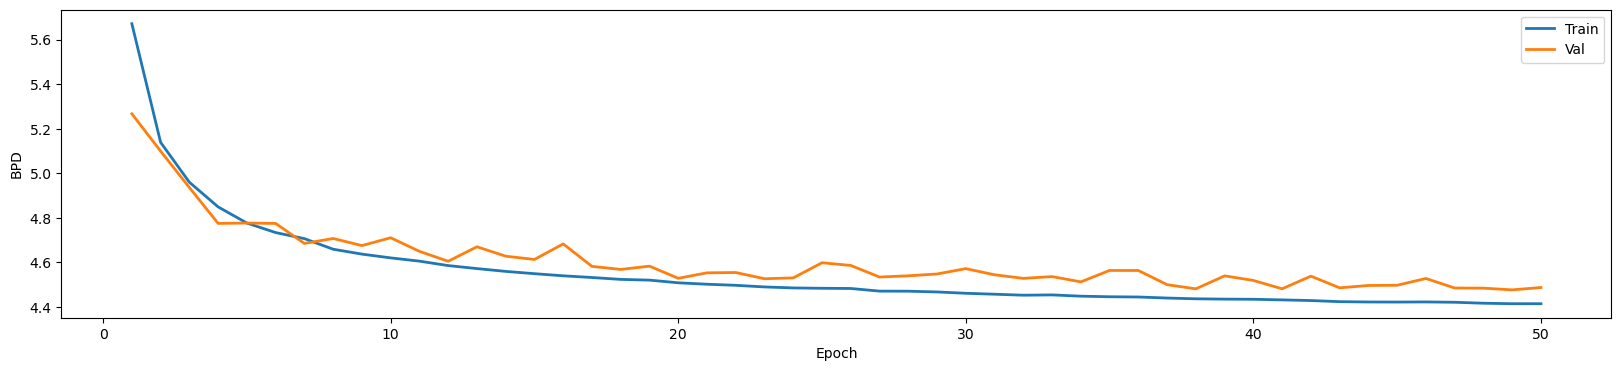

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))
(line1,) = ax.plot(df["epoch"], df["train_bpd"], label="Train", lw=2)
(line2,) = ax.plot(df["epoch"], df["val_bpd"], label="Val", lw=2)
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("BPD")

Global seed set to 42
Global seed set to 42


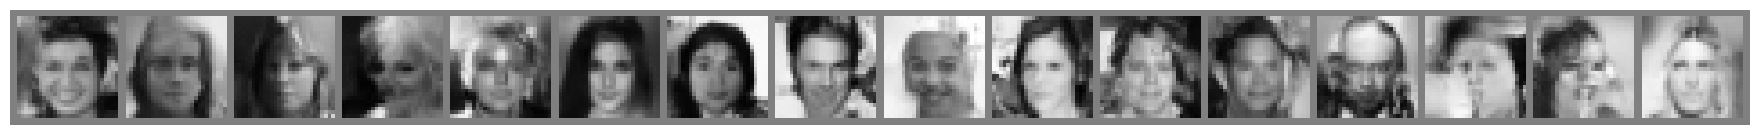

In [18]:
from lightning import LightningFlow

flow = create_multiscale_flow()
model = LightningFlow(flow, train_set[0][0]).to(device)
ckpt = torch.load('saved_models/Flow Multiscale/lightning_logs/version_10/checkpoints/epoch=48-step=19110.ckpt', map_location=device)
model.load_state_dict(ckpt["state_dict"])
result = ckpt.get("result", None)
pl.seed_everything(42)
num_samples = 16
model = model.to(device)
samples = model.flow.sample(shape=[num_samples, 8, 7, 7])
show_imgs(samples.cpu())

## Latent space interpolation and manipulation

Apart from sampling we can also use the trained model to manipulate images in the latent space.
We will do two small experiments in this section.

1. Image interpolation
2. adding and removing specific features from images

Image interpolation can be performed by producing the latent representations of 2 images and then computing new latent representations, which are convex combination of the two original latent representations.
These new latent representations can then be transformed back into image space using the inverse flow.
If everything works the resulting images should look like a gradual transition from one face to another. 


**Question:** If we had done interpolation directly in the image space instead, then the result would have looked much worse. Why is that?

===Your answer here===
Interpolating in image space means that one interpolates in between pixels independently, which probably does not correspond to interpolating between in the desired way between two faces.

In [19]:
@torch.no_grad()
def interpolate(model, img1, img2, num_steps=16):
    """
    Inputs:
        model - object of ImageFlow class that represents the (trained) flow model
        img1, img2 - Image tensors of shape [1, 28, 28]. Images between which should be interpolated.
        num_steps - Number of interpolation steps. 8 interpolation steps mean 6 intermediate pictures besides img1 and img2
    """
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    z, _ = model.flow(imgs)
    alpha = torch.linspace(0, 1, steps=num_steps, device=z.device).view(-1, 1, 1, 1)
    interpolations = z[0:1] * alpha + z[1:2] * (1 - alpha)
    interp_imgs = model.flow.inverse(interpolations)
    show_imgs(interp_imgs, row_size=num_steps)


exmp_imgs, _ = next(iter(train_data_loader))

Global seed set to 42


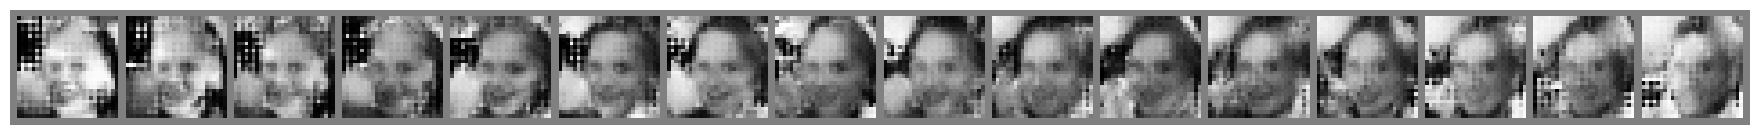

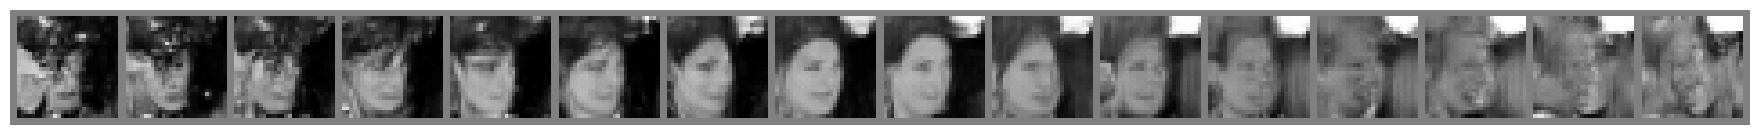

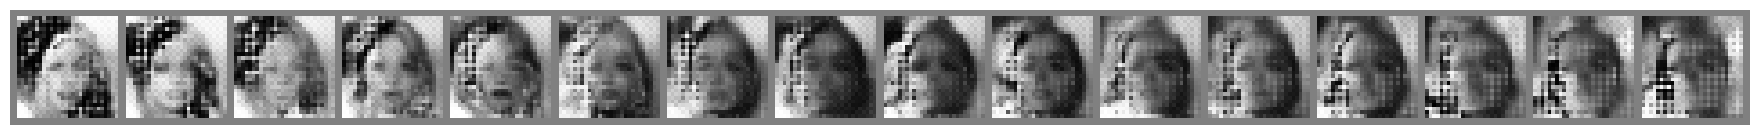

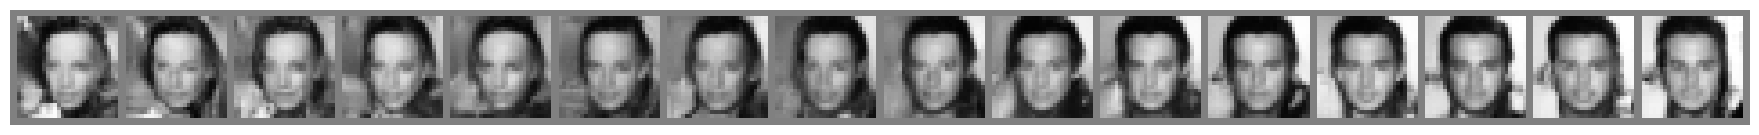

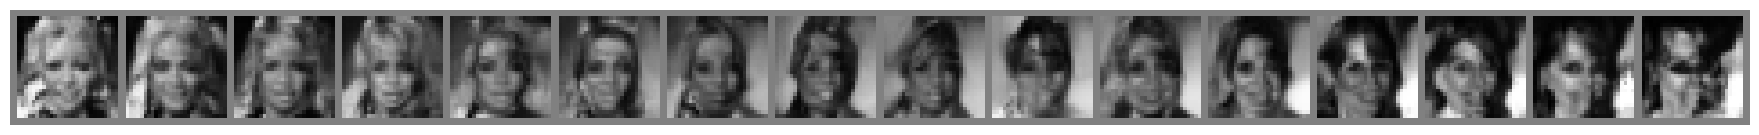

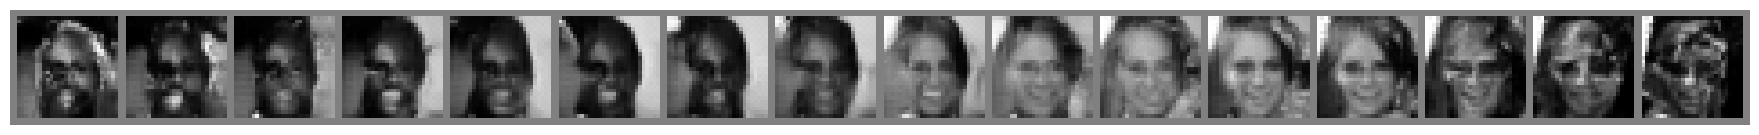

In [20]:
pl.seed_everything(42)
for i in range(6):
    interpolate(model, exmp_imgs[2 * i], exmp_imgs[2 * i + 1])

The CELEBA dataset has a large number of categorical labels/attributes, which are listed in the dictionary below (along with the index corresponding index in the datasets list of attributes).

Since we are working with a highly down-scaled version of CELEBA not all of these attributes will be very useful. For example "Bags_Under_Eyes" is not so useful due to the poor resolution of the image, but "Eyeglasses" is still very useful.

We start off by computing two lists containing arrays of all the positive and negative examples of each of the 40 attributes.

In [21]:
attr2idx_dict = {
    "5_o_Clock_Shadow": 0,
    "Arched_Eyebrows": 1,
    "Attractive": 2,
    "Bags_Under_Eyes": 3,
    "Bald": 4,
    "Bangs": 5,
    "Big_Lips": 6,
    "Big_Nose": 7,
    "Black_Hair": 8,
    "Blond_Hair": 9,
    "Blurry": 10,
    "Brown_Hair": 11,
    "Bushy_Eyebrows": 12,
    "Chubby": 13,
    "Double_Chin": 14,
    "Eyeglasses": 15,
    "Goatee": 16,
    "Gray_Hair": 17,
    "Heavy_Makeup": 18,
    "High_Cheekbones": 19,
    "Male": 20,
    "Mouth_Slightly_Open": 21,
    "Mustache": 22,
    "Narrow_Eyes": 23,
    "No_Beard": 24,
    "Oval_Face": 25,
    "Pale_Skin": 26,
    "Pointy_Nose": 27,
    "Receding_Hairline": 28,
    "Rosy_Cheeks": 29,
    "Sideburns": 30,
    "Smiling": 31,
    "Straight_Hair": 32,
    "Wavy_Hair": 33,
    "Wearing_Earrings": 34,
    "Wearing_Hat": 35,
    "Wearing_Lipstick": 36,
    "Wearing_Necklace": 37,
    "Wearing_Necktie": 38,
    "Young": 39,
}

In [22]:
attr_pos_indices = [train_set.tensors[1][:, i] == True for i in range(0, 40)]
pos_images = [train_set.tensors[0][attr_pos_indices[i], :, :, :] for i in range(0, 40)]

attr_neg_indices = [train_set.tensors[1][:, i] == False for i in range(0, 40)]
neg_images = [train_set.tensors[0][attr_neg_indices[i], :, :, :] for i in range(0, 40)]

The function modify_img takes an image $x$, an attribute of interest (e.g. "Eyeglasses") and the arrays of positive and negative examples defined above, and modifies the image $x$ to move towards the positive examples.

In order to do this we first compute latent representations of a subset of the positive and negative examples. We used two hundred, but feel free to adjust it if you run into GPU memory issues.

Next we take the mean of these vectors and subtract one from the other, i.e. $delta = z_{pos} - z_{neg}$.

This gives us a direction to move in in the latent space, in order to modify the embedding z of the input image x.

In practice it may be easier to modify images if you also normalize, so delta becomes $delta \gets delta\frac{||z||_2}{||delta||_2}$.


In [23]:
@torch.no_grad()
def modify_img(model, x, attribute, gain, pos_images, neg_images, num_steps=16):
    class_idx = attr2idx_dict[attribute]

    x_pos = pos_images[class_idx][
        0 : np.minimum(200, len(pos_images[class_idx])), :, :, :
    ].to(model.device)
    x_neg = neg_images[class_idx][
        0 : np.minimum(200, len(neg_images[class_idx])), :, :, :
    ].to(model.device)

    z, _ = model.flow(x)
    z_pos, _ = model.flow(x_pos)
    z_neg, _ = model.flow(x_neg)
    delta = z_pos.mean(axis=0) - z_neg.mean(axis=0)

    norm_z = z.norm()
    norm_delta = delta.norm()
    delta = gain * delta * norm_z / norm_delta
    alpha = torch.linspace(0, 1.0, steps=num_steps, device=z.device).view(-1, 1, 1, 1)
    z_altered = z + alpha * delta

    x_altered = model.flow.inverse(z_altered)

    notstring = "not " * (gain < 0)
    show_imgs(
        x_altered,
        row_size=num_steps,
        title='Increasing "' + notstring + attribute + '"-ness-->',
    )

Run the following cell to plot some modified images.

Note that sign of the gain controls whether we are trying to add or remove a feature.

**Question:** Try adding and removing different features by changing the arguments to the cell below. What do you observe? What does this experiment tell you about the latent space?

It seem to work ok to add the latent vectors corresponding to the different attributes. Smilingness seem to work the best. It is not clear what one can say about the latent space from the images displayed below. Adding something like youngness is different to adding eyeglasses since youngness is several attributes that should change whereas adding eyeglasses adds a distinct object onto the appropriate place. It is possible that adding eyeglasses will be coupled with adding "age" since more old people wear eyeglasses. This is an undesired feature, but it is not clear from the images below whether this is an issue here.

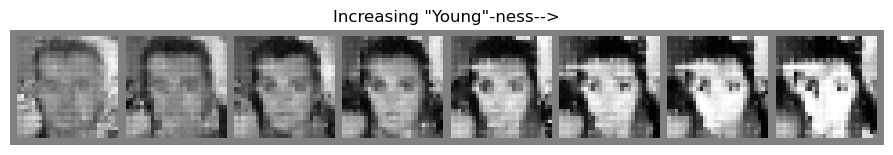

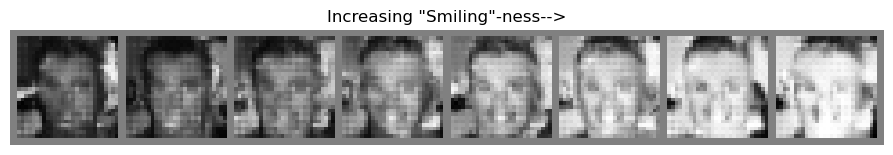

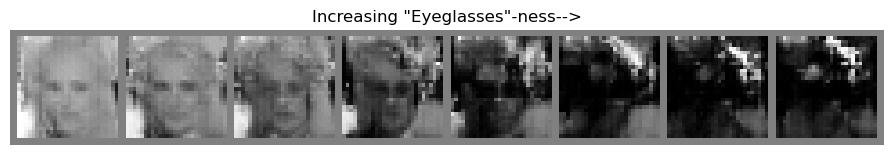

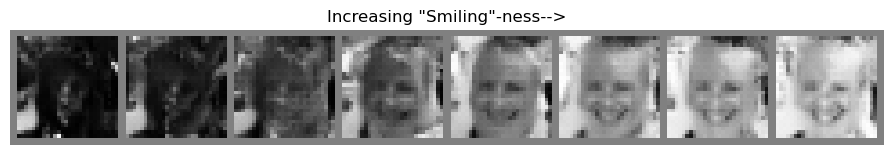

In [38]:
x1 = exmp_imgs[6].to(model.device).unsqueeze(axis=0)
x2 = exmp_imgs[25].to(model.device).unsqueeze(axis=0)

# List of gain factors and attributes for image x1
gain_list_1 = [1,0.5] # Implement this (a list of floats)
attr_list_1 = ["Young","Smiling"]# Implement this (a list of strings corresponding to the attributes you want to add or remove)

# List of gain factors and attributes for image x2
gain_list_2 = [0.5, 0.5] # Implement this
attr_list_2 = ["Eyeglasses", "Smiling"]# Implement this

# Modify image x1
for (gain, attr) in zip(gain_list_1, attr_list_1):
    modify_img(model, x1, attr, gain, pos_images, neg_images, num_steps=8)

# Modify image x2
for (gain, attr) in zip(gain_list_2, attr_list_2):
    modify_img(model, x2, attr, gain, pos_images, neg_images, num_steps=8)


Below we use the learned model to modify an image of Zlatan, but since our model was trained on 28x28 images we need to downscale the image first. 

If you want to make things extra fun, you can put in your own portrait here instead.

In [31]:
from PIL import Image

img_file = "zlatan.jpeg"  # Replace with your own face (optional) 

test_img = Image.open(img_file).convert("L")
width, height = test_img.width, test_img.height
delta_w = (np.abs(width - height) // 2) * (width > height)
delta_h = (np.abs(width - height) // 2) * (width <= height)

test_img = test_img.crop((delta_w, 0, width - delta_w, height))
test_img = test_img.resize((28, 28))
test_img = (
    torch.tensor(np.stack((test_img,), axis=-1))
    .squeeze(-1)
    .unsqueeze(0)
    .unsqueeze(0)
    .to(model.device)
)

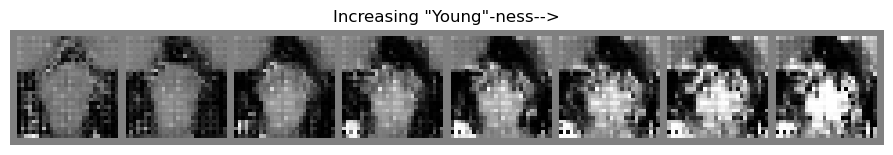

In [29]:
gain_list = [1] # Implement this
attr_list = ["Young"]# Implement this

for (gain, attr) in zip(gain_list, attr_list):
    modify_img(model, test_img, attr, gain, pos_images, neg_images, num_steps=8)

### Final reflections
**Question:** What are the advantages and disadvantages of normalizing flows compared to GANs and VAEs?

With normalizing flows one can evaluate the exact likelihood of a sample. I.e, density estimation is feasible. Neither VAEs or GANS are optimized on the exact likelihood.

The disadvantages are that one has to construct flows that are invertible, which puts a significant restriction on the networks that can be used. Also, computing the determinant of the jacobian is a computationally expensive process.